In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr

In [ ]:
df = pd.read_csv("/content/Case Study Chapter 3 Topic 3_ Dataset Kebotakan (Not Clean).csv")

df.head()

,umur,jenis_kelamin,pekerjaan,provinsi,gaji,is_menikah,is_keturunan,berat,tinggi,sampo,is_merokok,pendidikan,stress,botak_prob
0,27.0,Perempuan,PNS,Bengkulu,7.957453e+06,1.0,0.0,54.315053,170.428542,Pantone,1.0,S1,5.0,0.605974
1,53.0,Perempuan,PNS,Bandung,7.633003e+06,1.0,0.0,72.873404,165.530097,Pantone,0.0,S1,7.0,0.532860
2,37.0,Perempuan,Pegawai swasta,Bandung,6.637625e+06,1.0,0.0,46.321533,154.599388,Moonsilk,0.0,S1,4.0,0.418442
3,36.0,Perempuan,Pengangguran,Palu,3.624871e+06,1.0,0.0,51.539781,167.340481,Deadbuoy,1.0,SD,9.0,0.804050
4,38.0,Laki-laki,Freelance,Palangkaraya,6.031808e+06,1.0,0.0,60.726909,165.514773,Merpati,1.0,S2,1.0,0.368371


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7917 entries, 0 to 7916
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   umur           7832 non-null   float64
 1   jenis_kelamin  7840 non-null   object 
 2   pekerjaan      7760 non-null   object 
 3   provinsi       7831 non-null   object 
 4   gaji           7843 non-null   float64
 5   is_menikah     7845 non-null   float64
 6   is_keturunan   7828 non-null   float64
 7   berat          7861 non-null   float64
 8   tinggi         7843 non-null   float64
 9   sampo          7858 non-null   object 
 10  is_merokok     7847 non-null   float64
 11  pendidikan     7847 non-null   object 
 12  stress         7853 non-null   float64
 13  botak_prob     7838 non-null   float64
dtypes: float64(9), object(5)
memory usage: 866.0+ KB


# EDA

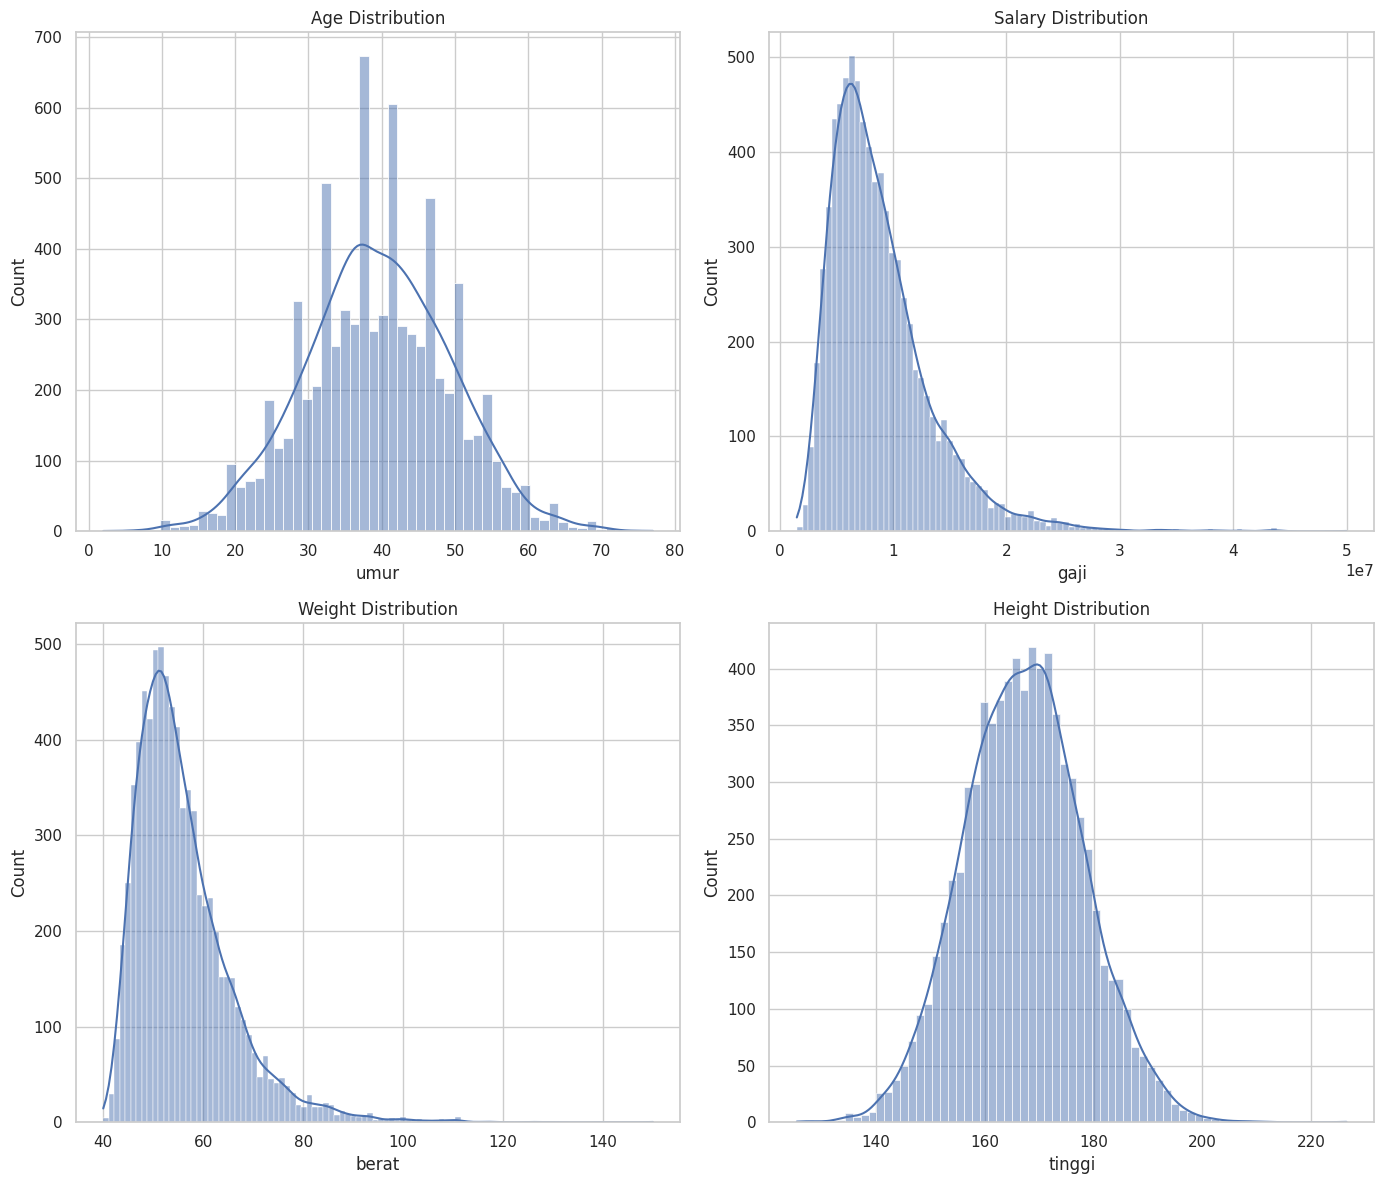

In [ ]:
sns.set(style="whitegrid")

# Visualisasi untuk data numerikal
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

sns.histplot(data=df, x='umur', kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribusi Umur')

sns.histplot(data=df, x='gaji', kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribusi Gaji')

sns.histplot(data=df, x='berat', kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribusi Berat Badan')

sns.histplot(data=df, x='tinggi', kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribusi Tinggi Badan')

plt.tight_layout()
plt.show()

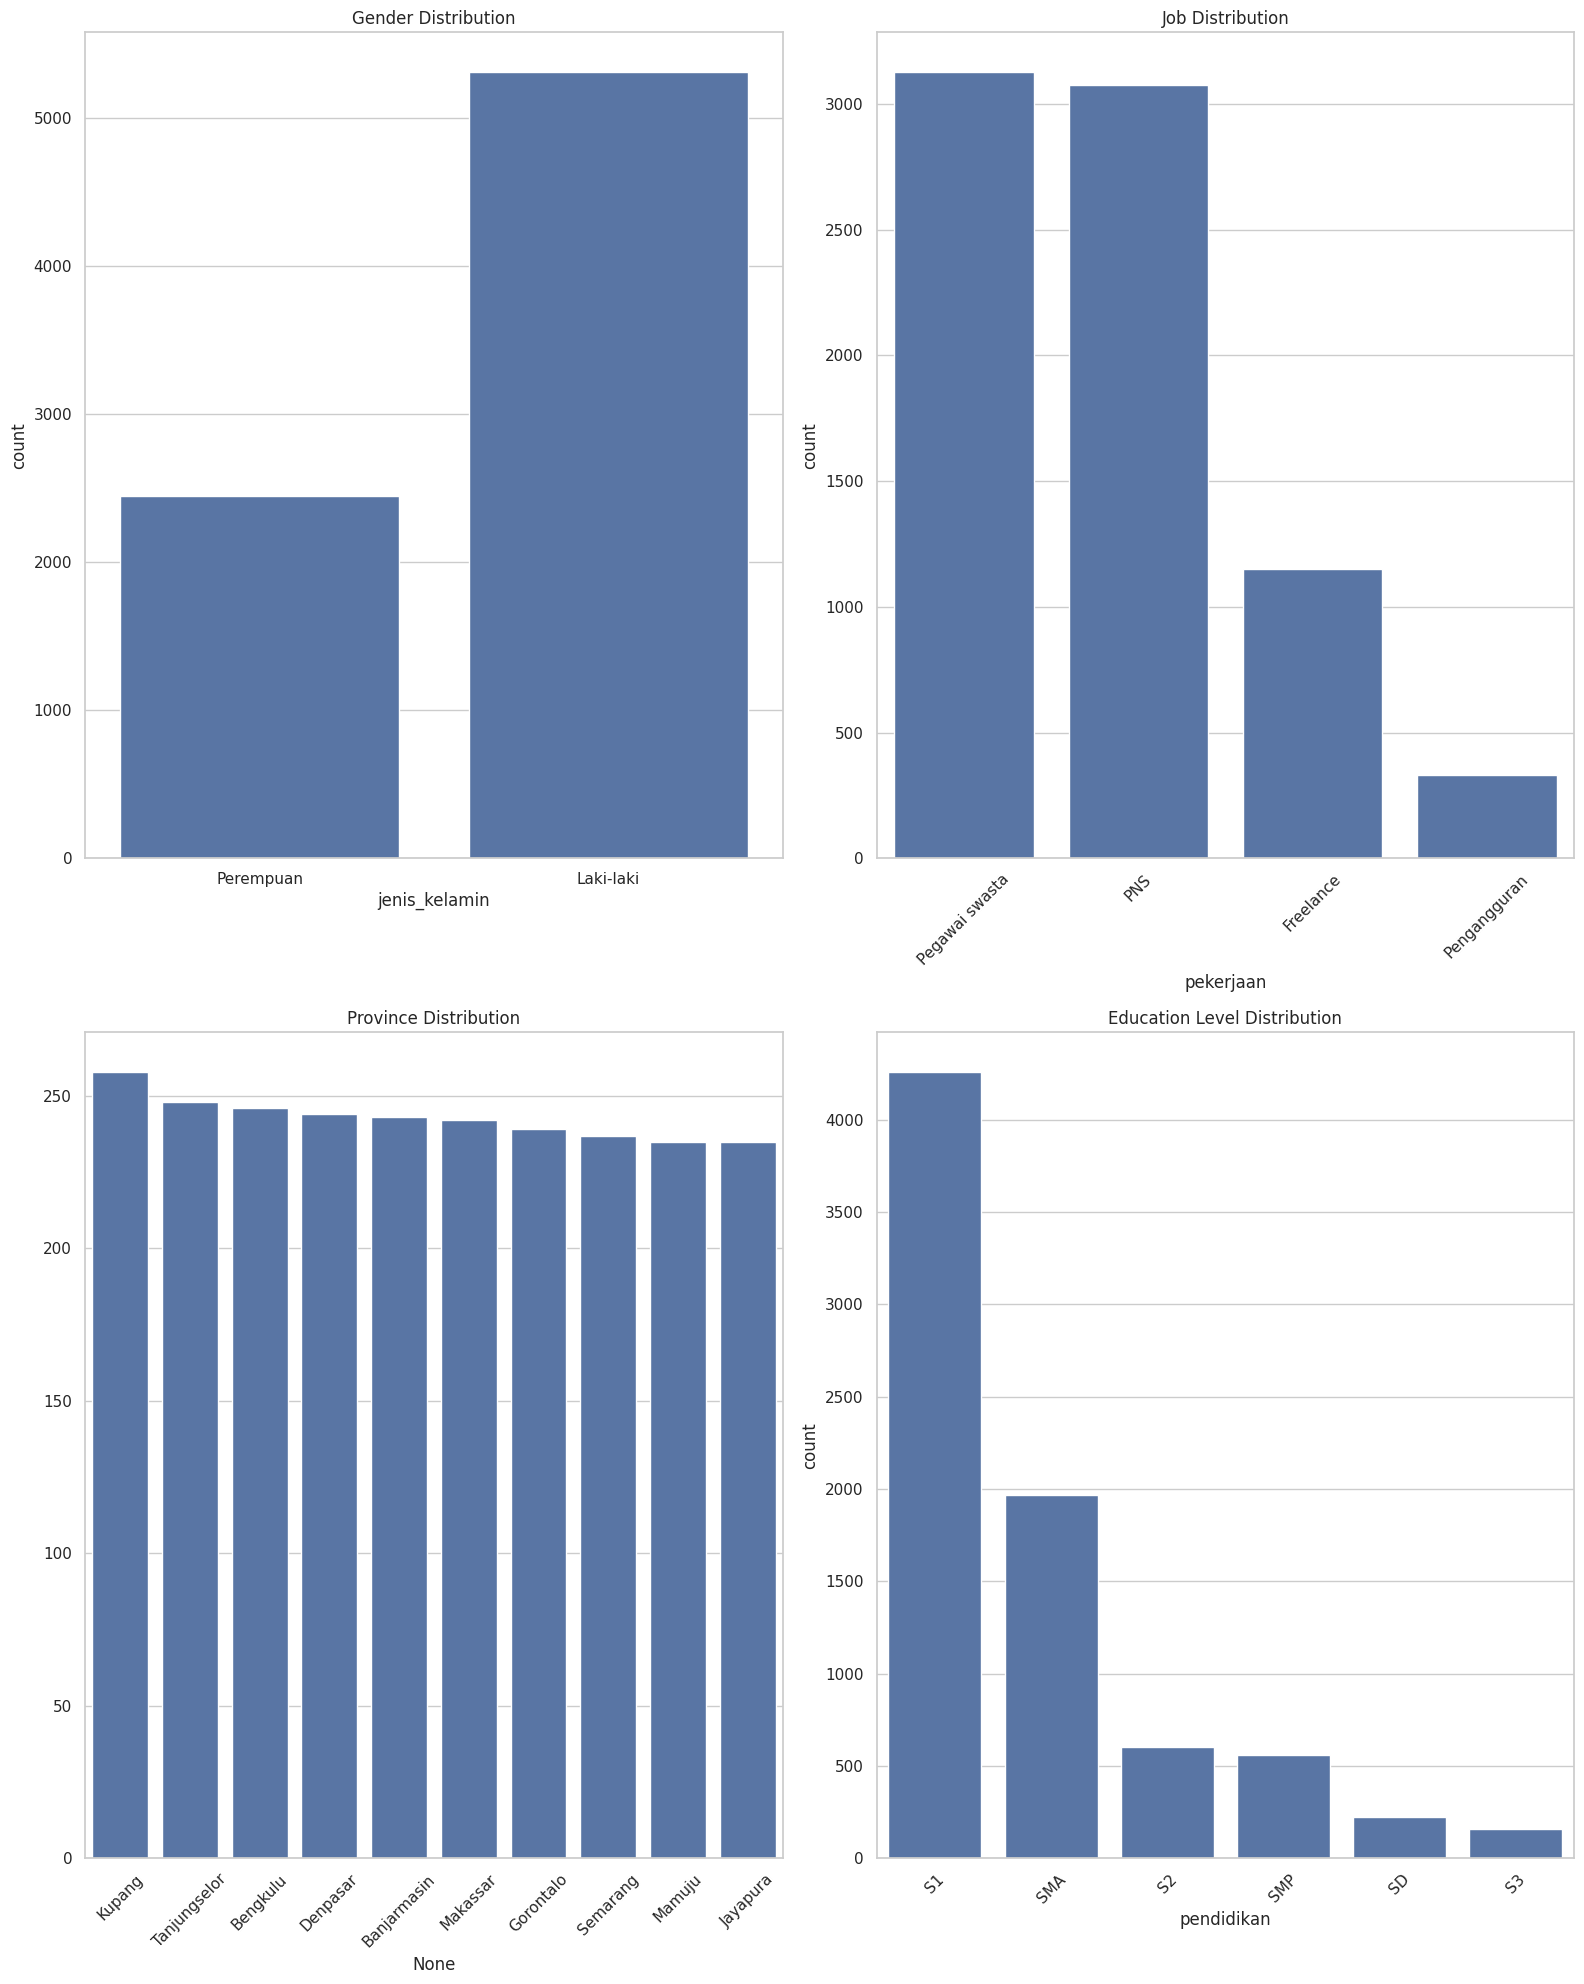

In [ ]:
# Visualisasi untuk data kategorikal
fig, axs = plt.subplots(2, 2, figsize=(16, 20))

sns.countplot(data=df, x='jenis_kelamin', ax=axs[0, 0])
axs[0, 0].set_title('Jenis Kelamin')

order = df['pekerjaan'].value_counts().index
sns.countplot(data=df, x='pekerjaan', order=order, ax=axs[0, 1])
axs[0, 1].set_title('Jenis Pekerjaan')
axs[0, 1].tick_params(axis='x', rotation=45)

top_pekerjaan = df['provinsi'].value_counts().nlargest(10)
sns.barplot(x=top_pekerjaan.index, y=top_pekerjaan.values, ax=axs[1, 0])
axs[1, 0].set_title('Persebaran Provinsi')
axs[1, 0].tick_params(axis='x', rotation=45)

order = df['pendidikan'].value_counts().index
sns.countplot(data=df, x='pendidikan', order=order, ax=axs[1, 1])
axs[1, 1].set_title('Persebaran Tingkat Edukasi')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


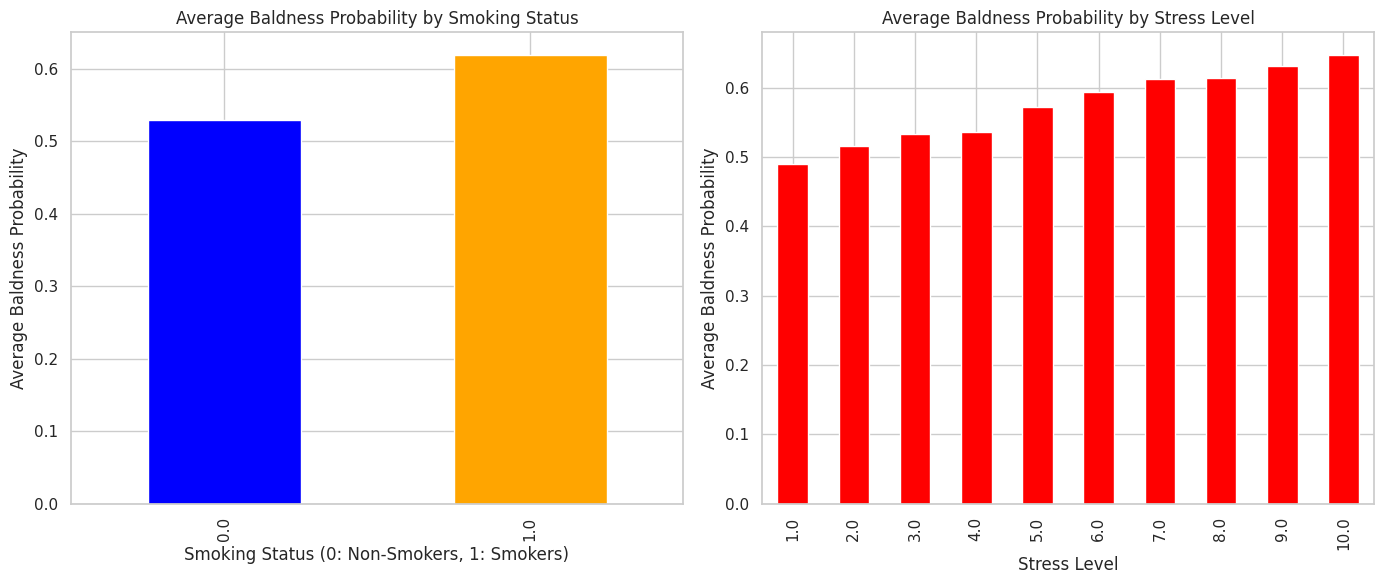

In [ ]:
# Menghapus null dan infinite
df_clean = df.dropna(subset=['umur', 'botak_prob'])
df_clean = df_clean[(np.isfinite(df_clean['umur'])) & (np.isfinite(df_clean['botak_prob']))]

avg_baldness_smokers = df_clean.groupby('is_merokok')['botak_prob'].mean()
avg_baldness_stress = df_clean.groupby('stress')['botak_prob'].mean()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
avg_baldness_smokers.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Baldness Probability by Smoking Status')
plt.xlabel('Smoking Status (0: Non-Smokers, 1: Smokers)')
plt.ylabel('Average Baldness Probability')

plt.subplot(1, 2, 2)
avg_baldness_stress.plot(kind='bar', color='red')
plt.title('Average Baldness Probability by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Average Baldness Probability')

plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
num_cols = ['umur', 'gaji', 'berat', 'tinggi', 'stress']
cat_cols = ['jenis_kelamin', 'pekerjaan', 'provinsi', 'sampo', 'pendidikan']
binary_cols = ['is_menikah', 'is_keturunan', 'is_merokok']

# Pipeline untuk numerikal
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline untuk kategorikal
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

binary_pipeline = cat_pipeline

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
    ('binary', binary_pipeline, binary_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Training Model

In [ ]:
df = df.dropna(subset=['botak_prob'])
X = df.drop('botak_prob', axis=1)
y = df['botak_prob']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
y_pred

array([0.74787405, 0.57030493, 0.44752536, ..., 0.40691929, 0.59800101,
       0.45376226])

# Evaluation

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.05207177895152926
Mean Squared Error (MSE): 0.0049865143814605195
Root Mean Squared Error (RMSE): 0.07061525601072703
R-squared (R²): 0.840976878683436
